In [11]:
import numpy as np
import pandas as pd
from ast import literal_eval
import os
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import json
from tqdm.notebook import tqdm

tqdm.pandas()  # for pandas progress_apply()

import shutil

In [12]:
# reload sub-modules on change
# UsageError: Line magic function `%` not found. -> make sure it's '%load_ext autoreload' and not '% load_ext autoreload' (with space)
%load_ext autoreload
%autoreload 2

sns.set(rc={'figure.figsize': (20, 6)})
sns.set(font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper Functions

In [13]:
def get_images_from_imagelist(image_list_path):
    with open(image_list_path, "r") as f:
        return np.array(f.read().splitlines())


def image_name_to_index(fname, imagelist):
    try:
        return int(np.where(imagelist == fname)[0][0])
    except IndexError:
        # print("index error in get_images_from_imagelist")
        return 0


def get_centroid_idx(idxs, features, top_n=5, distance_metric="cosine"):
    """
    Get most central images based on a list of image indices
    :param idxs: list of imge indices
    :param features: feature vector of the images. The image indices should be w.r.t these features (e.g. image #2 has feature vector #2)
        :param top_n: get n most central images
    :param distance_metric: cosine/euclidean metric for distance comparisons
    :return: list of indices
    """
    features_cluster = features[idxs]
    # find most central point (=center) in cluster
    avg_point = np.mean(features_cluster, axis=0)

    # get distance of each image in cluster to the center
    if distance_metric == "cosine":
        distances = np.dot(features_cluster, avg_point)
    else:
        distances = np.linalg.norm(features_cluster - avg_point, axis=1)

    # get top n most central images based on distance to center
    indices_cosine_sorted = np.argsort(distances)  # returns indices sorted by ascending sort values
    if distance_metric == "cosine":
        # relative = indices are w.r.t to the images in cluster, not all images
        idxs_relative = indices_cosine_sorted[::-1][:top_n]
    else:
        idxs_relative = indices_cosine_sorted[::1][:top_n]

    return np.array(idxs)[idxs_relative]


# Prep

In [14]:
features = np.load("feature_vectors.npy")
db_all = get_images_from_imagelist("image_db.txt")
db_all_folder = "image_db"
label_df_project = pd.read_csv("image_labels.csv")

# Convert table structure into dictionary
grouped_df = label_df_project.groupby('Building')['Image'].apply(list)
macro_cluster_dict = grouped_df.to_dict()

output_file = os.path.join("entourage.png")

# Clustering 2D Visualization
Inspired by: http://lab.softwarestudies.com/2015/11/visualizing-high-dimensional-image_16.html
General idea:
1. PCA image feature vectors down to 2 dimensions.
2. For each cluster, pick the most central image (centroid).
3. Start with an empty 2D canvas which is organized in a grid.
4. Each centroid (representing its cluster) gets to pick the closest image to it (closeness = feature vector distance) and put it on the canvas.
5. Repeat 4. until desired plot size is reached.

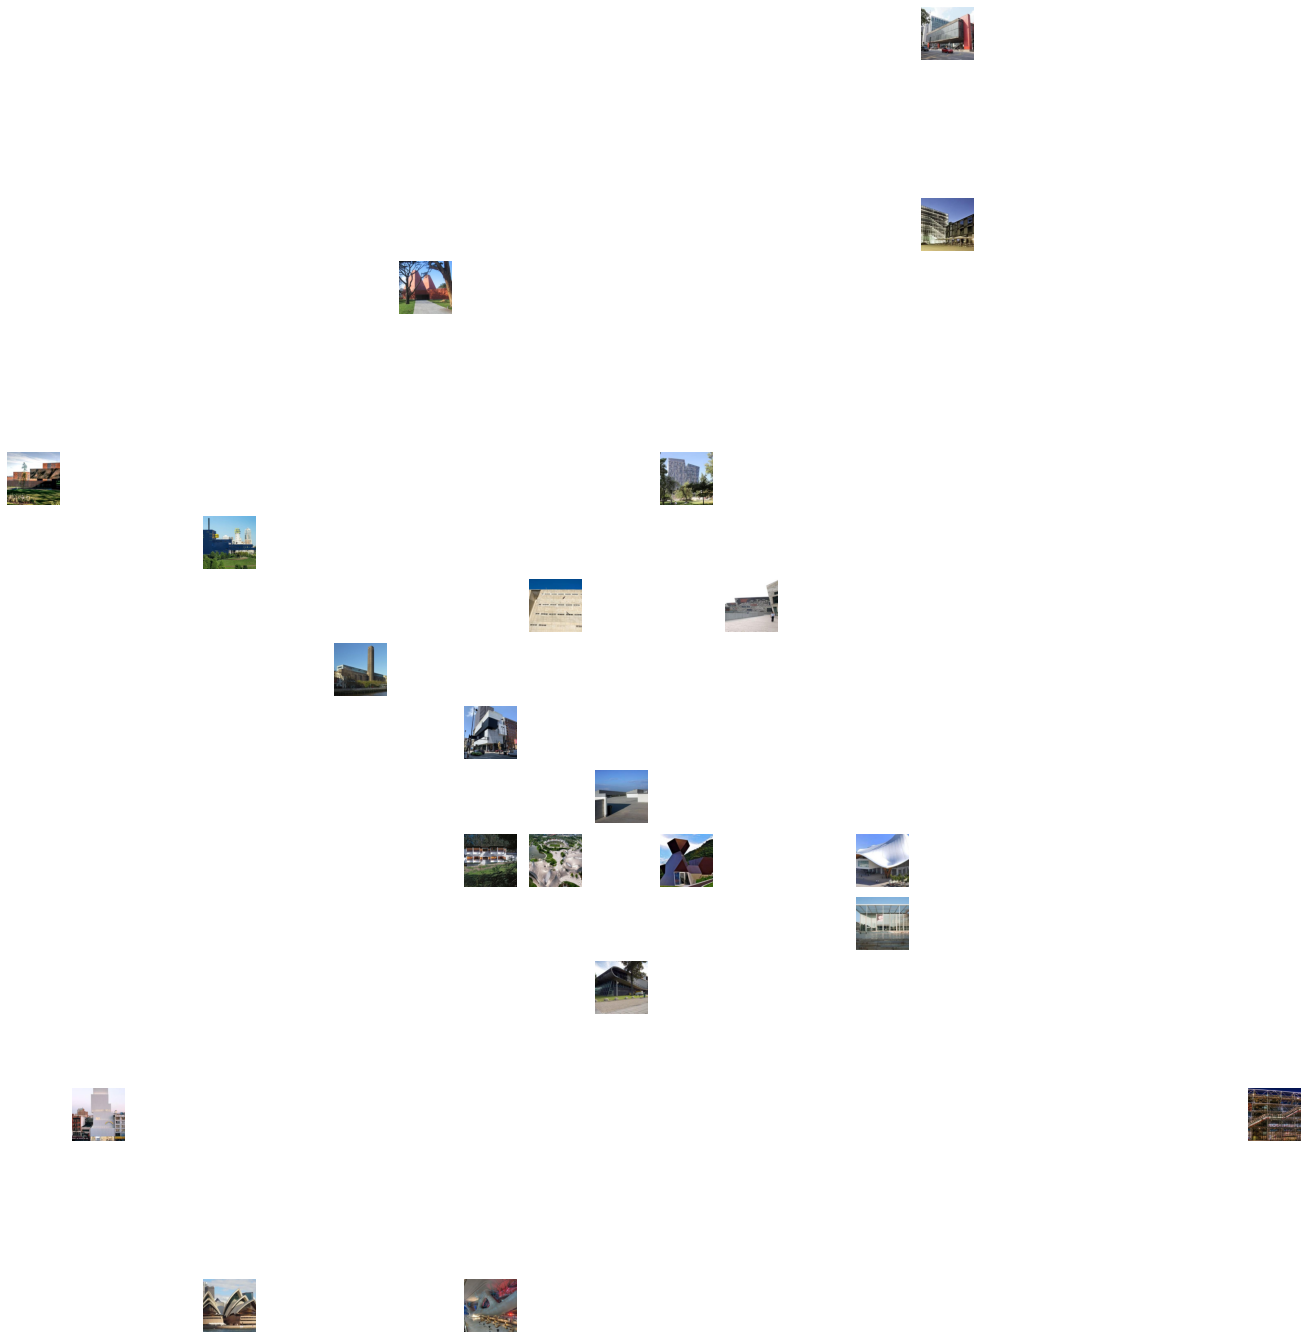

<Figure size 5040x5040 with 0 Axes>

In [15]:
def scale_to_canvas(xy, canvas_size):
    """
    Scales an array of X,Y coordinates to the size of the canvas
    :param xy: np array of dims Nx2
    :param canvas_size: size to scale to
    returns: scaled X,Y coordinates of dims Nx2
    """
    x = xy[:, 0]
    y = xy[:, 1]
    # normalize to 0-1 and scale to canvas
    x = (x - min(x)) / (max(x) - min(x)) * canvas_size[0]
    y = (y - min(y)) / (max(y) - min(y)) * canvas_size[1]

    # return 2D aray
    return np.column_stack((x.astype(int), y.astype(int)))


def growing_entourage_plot(features, macro_cluster_dict, db_all, db_all_folder, rounds=1,
                           output_file="entourage_plot.png", image_copy_folder="enourage_images"):
    os.makedirs(image_copy_folder, exist_ok=True)

    pca = PCA(n_components=2)
    features_pca_2 = pca.fit_transform(features)

    # convert img names to indices to prepare for clustering
    macro_cluster_idx_dict = {}
    for cluster_name, files in macro_cluster_dict.items():
        macro_cluster_idx_dict[cluster_name] = list(map(lambda x: image_name_to_index(x, db_all), files))

    canvas_size = (
    60, 60)  # -> smaller canvas produces more dense image, larger canvas produces more spread out clusters
    pad = (0, 0)  # empty space on the sides

    xy_taken = []

    # collect centroids (represented by index) for each cluster
    centroids_to_plot = {}
    xy_to_plot = {}
    for cluster_name, idxs in macro_cluster_idx_dict.items():
        centroids = get_centroid_idx(idxs, features=features_pca_2, top_n=len(idxs), distance_metric="euclidean")
        centroids_to_plot[cluster_name] = centroids
        xy = features_pca_2[centroids]
        xy_to_plot[cluster_name] = scale_to_canvas(xy, canvas_size)

    figsize = 70
    fig = plt.figure(figsize=(figsize, figsize))
    fig2 = plt.figure(figsize=(figsize, figsize))
    n_rows = canvas_size[0] + pad[0] * 2
    n_cols = canvas_size[1] + pad[1] * 2

    for round in range(rounds):
        for building in macro_cluster_dict.keys():
            cluster_name = building

            xy = xy_to_plot[cluster_name]
            centroids = centroids_to_plot[cluster_name]

            x = xy[:, 0]
            y = xy[:, 1]

            # find centroid to plot (lazily iterate through all centroids until we find one with an empty slot) - runtime is not a big concern with these plots
            for i, idx in enumerate(centroids):
                x_img, y_img = x[i] + pad[0], y[i] + pad[1]
                # plot image on subplot but only if the spot is not taken yet
                if (x_img, y_img) not in xy_taken:
                    plot_idx = (((x_img + 1) % n_rows) - 1) * n_rows + (y_img + 1)  # xy->field 'number' conversion
                    img_path = os.path.join(db_all_folder, db_all[idx])
                    img = plt.imread(img_path)

                    # save image to folder
                    shutil.copy2(img_path, os.path.join(image_copy_folder, db_all[idx]))

                    ax = fig.add_subplot(n_rows, n_cols, plot_idx)
                    ax.imshow(img)
                    ax.axis('off')

                    xy_taken.append((x_img, y_img))
                    break

        # tight_layout will screw up the solid color figure for some reason
        fig.savefig(output_file)
        name, ext = output_file.split(".")
        output_file2 = "{}_solid.{}".format(name, ext)
        fig2.savefig(output_file2)


rounds = 1
growing_entourage_plot(features, macro_cluster_dict, db_all, db_all_folder, rounds, output_file, image_copy_folder)